In [45]:
from functools import partial
from typing import Sequence, Tuple, Union

import pytorch_lightning  as L
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as VisionF
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from torch import Tensor
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import CIFAR10
from torchvision.models.resnet import resnet18
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import lightly.data as data

batch_size = 32
num_workers = 0  # to run notebook on CPU
max_epochs = 200
z_dim = 128

In [46]:
class BarlowTwinsTransform:
    def __init__(self, train=True, input_height=224, gaussian_blur=True, jitter_strength=1.0, normalize=None):
        self.input_height = input_height
        self.gaussian_blur = gaussian_blur
        self.jitter_strength = jitter_strength
        self.normalize = normalize
        self.train = train

        color_jitter = transforms.ColorJitter(
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.2 * self.jitter_strength,
        )

        color_transform = [transforms.RandomApply([color_jitter], p=0.8), transforms.RandomGrayscale(p=0.2)]

        if self.gaussian_blur:
            kernel_size = int(0.1 * self.input_height)
            if kernel_size % 2 == 0:
                kernel_size += 1

            color_transform.append(transforms.RandomApply([transforms.GaussianBlur(kernel_size=kernel_size)], p=0.5))

        self.color_transform = transforms.Compose(color_transform)

        if normalize is None:
            self.final_transform = transforms.ToTensor()
        else:
            self.final_transform = transforms.Compose([transforms.ToTensor(), normalize])

        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(self.input_height),
                transforms.RandomHorizontalFlip(p=0.5),
                self.color_transform,
                self.final_transform,
            ]
        )

        self.finetune_transform = None
        if self.train:
            self.finetune_transform = transforms.Compose(
                [
                    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ]
            )
        else:
            self.finetune_transform = transforms.ToTensor()

    def __call__(self, sample):
        return self.transform(sample), self.transform(sample), self.finetune_transform(sample)

In [10]:
def cifar10_normalization():
    normalize = transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
    )
    return normalize


train_transform = BarlowTwinsTransform(
    train=True, input_height=32, gaussian_blur=False, jitter_strength=0.5, normalize=cifar10_normalization()
)
train_dataset = CIFAR10(root=".", train=True, download=True, transform=train_transform)

val_transform = BarlowTwinsTransform(
    train=False, input_height=32, gaussian_blur=False, jitter_strength=0.5, normalize=cifar10_normalization()
)
val_dataset = CIFAR10(root=".", train=False, download=True, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .\cifar-10-python.tar.gz to .
Files already downloaded and verified


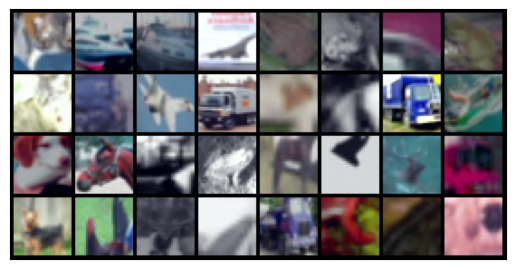

In [11]:
for batch in val_loader:
    (img1, img2, _), label = batch
    break

img_grid = make_grid(img1, normalize=True)


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VisionF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


show(img_grid)

In [12]:
class BarlowTwinsLoss(nn.Module):
    def __init__(self, batch_size, lambda_coeff=5e-3, z_dim=128):
        super().__init__()

        self.z_dim = z_dim
        self.batch_size = batch_size
        self.lambda_coeff = lambda_coeff

    def off_diagonal_ele(self, x):
        # taken from: https://github.com/facebookresearch/barlowtwins/blob/main/main.py
        # return a flattened view of the off-diagonal elements of a square matrix
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def forward(self, z1, z2):
        # N x D, where N is the batch size and D is output dim of projection head
        z1_norm = (z1 - torch.mean(z1, dim=0)) / torch.std(z1, dim=0)
        z2_norm = (z2 - torch.mean(z2, dim=0)) / torch.std(z2, dim=0)

        cross_corr = torch.matmul(z1_norm.T, z2_norm) / self.batch_size

        on_diag = torch.diagonal(cross_corr).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal_ele(cross_corr).pow_(2).sum()

        return on_diag + self.lambda_coeff * off_diag

In [13]:
encoder = resnet18()

# for CIFAR10, replace the first 7x7 conv with smaller 3x3 conv and remove the first maxpool
encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
encoder.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

# replace classification fc layer of Resnet to obtain representations from the backbone
encoder.fc = nn.Identity()

In [14]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=2048, output_dim=128):
        super().__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=True),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=False),
        )

    def forward(self, x):
        return self.projection_head(x)

In [15]:
def fn(warmup_steps, step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    else:
        return 1.0


def linear_warmup_decay(warmup_steps):
    return partial(fn, warmup_steps)

In [16]:
class BarlowTwins(L.LightningModule):
    def __init__(
        self,
        encoder,
        encoder_out_dim,
        num_training_samples,
        batch_size,
        lambda_coeff=5e-3,
        z_dim=128,
        learning_rate=1e-4,
        warmup_epochs=10,
        max_epochs=200,
    ):
        super().__init__()

        self.encoder = encoder
        self.projection_head = ProjectionHead(input_dim=encoder_out_dim, hidden_dim=encoder_out_dim, output_dim=z_dim)
        self.loss_fn = BarlowTwinsLoss(batch_size=batch_size, lambda_coeff=lambda_coeff, z_dim=z_dim)

        self.learning_rate = learning_rate
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs

        self.train_iters_per_epoch = num_training_samples // batch_size

    def forward(self, x):
        return self.encoder(x)

    def shared_step(self, batch):
        (x1, x2, _), _ = batch

        z1 = self.projection_head(self.encoder(x1))
        z2 = self.projection_head(self.encoder(x2))

        return self.loss_fn(z1, z2)

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("val_loss", loss, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        warmup_steps = self.train_iters_per_epoch * self.warmup_epochs

        scheduler = {
            "scheduler": torch.optim.lr_scheduler.LambdaLR(
                optimizer,
                linear_warmup_decay(warmup_steps),
            ),
            "interval": "step",
            "frequency": 1,
        }

        return [optimizer], [scheduler]

In [17]:
class OnlineFineTuner(Callback):
    def __init__(
        self,
        encoder_output_dim: int,
        num_classes: int,
    ) -> None:
        super().__init__()

        self.optimizer: torch.optim.Optimizer

        self.encoder_output_dim = encoder_output_dim
        self.num_classes = num_classes

    def on_fit_start(self, trainer: L.Trainer, pl_module: L.LightningModule) -> None:
        # add linear_eval layer and optimizer
        pl_module.online_finetuner = nn.Linear(self.encoder_output_dim, self.num_classes).to(pl_module.device)
        self.optimizer = torch.optim.Adam(pl_module.online_finetuner.parameters(), lr=1e-4)

    def extract_online_finetuning_view(
        self, batch: Sequence, device: Union[str, torch.device]
    ) -> Tuple[Tensor, Tensor]:
        (_, _, finetune_view), y = batch
        finetune_view = finetune_view.to(device)
        y = y.to(device)

        return finetune_view, y

    def on_train_batch_end(
        self,
        trainer: L.Trainer,
        pl_module: L.LightningModule,
        outputs: Sequence,
        batch: Sequence,
        batch_idx: int,
    ) -> None:
        x, y = self.extract_online_finetuning_view(batch, pl_module.device)

        with torch.no_grad():
            feats = pl_module(x)

        feats = feats.detach()
        preds = pl_module.online_finetuner(feats)
        loss = F.cross_entropy(preds, y)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        acc = accuracy(F.softmax(preds, dim=1), y, task="multiclass", num_classes=10)
        pl_module.log("online_train_acc", acc, on_step=True, on_epoch=False)
        pl_module.log("online_train_loss", loss, on_step=True, on_epoch=False)

    def on_validation_batch_end(
        self,
        trainer: L.Trainer,
        pl_module: L.LightningModule,
        outputs: Sequence,
        batch: Sequence,
        batch_idx: int,
    ) -> None:
        x, y = self.extract_online_finetuning_view(batch, pl_module.device)

        with torch.no_grad():
            feats = pl_module(x)

        feats = feats.detach()
        preds = pl_module.online_finetuner(feats)
        loss = F.cross_entropy(preds, y)

        acc = accuracy(F.softmax(preds, dim=1), y, task="multiclass", num_classes=10)
        pl_module.log("online_val_acc", acc, on_step=False, on_epoch=True, sync_dist=True)
        pl_module.log("online_val_loss", loss, on_step=False, on_epoch=True, sync_dist=True)

In [20]:
encoder_out_dim = 512

model = BarlowTwins(
    encoder=encoder,
    encoder_out_dim=encoder_out_dim,
    num_training_samples=len(train_dataset),
    batch_size=batch_size,
    z_dim=z_dim,
)

online_finetuner = OnlineFineTuner(encoder_output_dim=encoder_out_dim, num_classes=10)
checkpoint_callback = ModelCheckpoint(every_n_epochs=100, save_top_k=-1, save_last=True)

trainer = L.Trainer(
    max_epochs=max_epochs,
    accelerator="auto",
    devices=1,
    callbacks=[online_finetuner, checkpoint_callback],
)

# uncomment this to train the model
# this is done for the tutorial so that the notebook compiles
trainer.fit(model, train_loader, val_loader)

ModelCheckpoint(save_last=True, save_top_k=-1, monitor=None) will duplicate the last checkpoint saved.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\leo22\Documents\ENSICAEN\Stage à l'étranger\Projet\lying-pen-scribes-project\machine_learning\CNN\lightning_logs

  | Name             | Type            | Params
-----------------------------------------------------
0 | encoder          | ResNet          | 11.2 M
1 | projection_head  | ProjectionHead  | 329 K 
2 | loss_fn          | BarlowTwinsLoss | 0     
3 | online_finetuner | Linear          | 5.1 K 
-----------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.013    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\leo22\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


TypeError: OnlineFineTuner.on_validation_batch_end() takes 6 positional arguments but 7 were given

In [19]:
encoder = model.encoder

downstream_dataset = CIFAR10(root=".", train=False, transform=transforms.ToTensor())
dataloader = DataLoader(downstream_dataset, batch_size=4, shuffle=False)

for batch in dataloader:
    img, label = batch
    print(encoder(img).shape)
    break

torch.Size([4, 512])


In [38]:
# Note: The model and training settings do not follow the reference settings
# from the paper. The settings are chosen such that the example can easily be
# run on a small dataset with a single GPU.

import torch
import torchvision
from torch import nn

from lightly.loss import BarlowTwinsLoss
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.transforms.byol_transform import (
    BYOLTransform,
    BYOLView1Transform,
    BYOLView2Transform,
)


class BarlowTwins(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z


resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BarlowTwins(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# BarlowTwins uses BYOL augmentations.
# We disable resizing and gaussian blur for cifar10.
transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(input_size=32, gaussian_blur=0.0),
    view_2_transform=BYOLView2Transform(input_size=32, gaussian_blur=0.0),
)
dataset = torchvision.datasets.CIFAR10(
    "datasets/cifar10", download=True, transform=transform
)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder", transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = BarlowTwinsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

x0, x1 = dataloader.dataset[0]
print(x0)
print("-----")
print(x1)

"""
print("Starting Training")
for epoch in range(10):
    total_loss = 0
    print(epoch)
    for batch in dataloader:
        print("ici")
        x0, x1 = batch[0]

        print(batch[0])
        
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
"""

print("fin")

Files already downloaded and verified
[tensor([[[ 1.0331,  1.0331,  1.0159,  ..., -0.9363, -0.7822, -0.7137],
         [ 0.9646,  0.9646,  0.9646,  ..., -0.5253, -0.3198, -0.2513],
         [ 0.8447,  0.8276,  0.8447,  ...,  0.2453,  0.5707,  0.6563],
         ...,
         [ 0.9474,  0.8447,  0.5707,  ...,  2.0434,  2.0777,  2.0434],
         [ 1.3070,  1.1872,  0.7933,  ...,  1.8893,  1.5297,  1.4269],
         [ 1.4783,  1.3413,  0.9132,  ...,  1.5982,  1.1700,  1.0844]],

        [[ 1.1856,  1.1856,  1.1681,  ..., -0.8277, -0.6702, -0.6001],
         [ 1.1155,  1.1155,  1.1155,  ..., -0.4076, -0.1975, -0.1275],
         [ 0.9930,  0.9755,  0.9930,  ...,  0.3803,  0.7129,  0.8004],
         ...,
         [ 1.0980,  0.9930,  0.7129,  ...,  2.2185,  2.2535,  2.2185],
         [ 1.4657,  1.3431,  0.9405,  ...,  2.0609,  1.6933,  1.5882],
         [ 1.6408,  1.5007,  1.0630,  ...,  1.7633,  1.3256,  1.2381]],

        [[ 1.4025,  1.4025,  1.3851,  ..., -0.6018, -0.4450, -0.3753],
      

In [41]:
# Custom Dataset to manage images (28x28) and their labels. Mainly related to the Dead Sea Scrolls.
class CustomDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        self.images = self.load_images(images_file)
        self.labels = self.load_labels(labels_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def load_images(self, file_path):
        with open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)  # Skip first 16 bytes
        num_images = len(data) // (28 * 28)
        data = data.reshape(num_images, 28, 28)
        return data.copy()  # Ensure the array is writable

    def load_labels(self, file_path):
        with open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.uint8, offset=8)  # Skip first 8 bytes
        return data

In [56]:
# Note: The model and training settings do not follow the reference settings
# from the paper. The settings are chosen such that the example can easily be
# run on a small dataset with a single GPU.

import torch
import torchvision
from torch import nn

from lightly.loss import BarlowTwinsLoss
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.transforms.byol_transform import (
    BYOLTransform,
    BYOLView1Transform,
    BYOLView2Transform,
)


class BarlowTwins(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z


resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BarlowTwins(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# BarlowTwins uses BYOL augmentations.
# We disable resizing and gaussian blur for cifar10.
transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(input_size=32, gaussian_blur=0.0),
    view_2_transform=BYOLView2Transform(input_size=32, gaussian_blur=0.0),
)

train_images_file = "../../datasets/dataset_from_PNAS/Arad_Ancient_Hebrew"
train_labels_file = "dataset/train-labels-idx1-ubyte"

dataset = data.LightlyDataset(train_images_file, transform=transform)

"""
dataset = torchvision.datasets.CIFAR10(
    "datasets/cifar10", download=True, transform=transform
)
"""
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder", transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=6,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = BarlowTwinsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)


print("Starting Training")
for epoch in range(10):
    total_loss = 0
    print(epoch)
    for batch in dataloader:
        x0, x1 = batch[0]
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

print("fin")

Starting Training
0
epoch: 00, loss: 6413.95459
1
epoch: 01, loss: 6332.43848
2
epoch: 02, loss: 6606.20361
3
epoch: 03, loss: 7157.27148
4
epoch: 04, loss: 5945.35742
5
epoch: 05, loss: 5809.58252
6


KeyboardInterrupt: 